In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone
from datetime import datetime
from skyfield.api import Loader, Topos
from skyfield.data import hipparcos
import satpred
import satplot

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
load = Loader('./data')

In [4]:
ts = load.timescale()
ephemeris = load('de421.bsp')
satellites = load.tle('http://celestrak.com/NORAD/elements/stations.txt', reload=True)
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

[#################################] 100% stations.txt


In [5]:
sun = ephemeris['sun']
earth = ephemeris['earth']
iss = satellites['ISS']
manhattan_beach_ca_usa = Topos(latitude='33.881519 N', longitude='118.388177 W', elevation_m=33)
pacific = timezone('US/Pacific')
bright_stars = df[df['magnitude'] <= 5.]

In [6]:
d0 = datetime(2019, 6, 1, 0, 0)
t0 = ts.utc(pacific.localize(d0))
d1 = datetime(2019, 6, 11, 0, 0)
t1 = ts.utc(pacific.localize(d1))

In [7]:
df = pd.DataFrame(satpred.passes(t0, t1, manhattan_beach_ca_usa, iss, earth, sun, pretty=True))

In [8]:
columns = ['date', 'peak_magnitude', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d']

In [9]:
df[columns]

,date,peak_magnitude,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d
0,2019-06-01,0.2,22:51:30,10,NW,1497,22:52:58,23,NW,923,22:52:59,23,NW,921
1,2019-06-02,-2.1,22:02:14,10,NNW,1496,22:05:18,34,NE,706,22:05:18,34,NE,706
2,2019-06-03,-1.7,21:13:09,10,NNW,1495,21:15:45,20,NNE,1014,21:17:40,13,ENE,1299
3,2019-06-03,0.0,22:49:24,10,WNW,1495,22:50:30,18,WNW,1102,22:50:30,18,WNW,1101
4,2019-06-04,-3.4,21:59:44,10,NW,1494,22:02:55,71,WSW,441,22:02:55,71,WSW,441
5,2019-06-05,-3.4,21:10:20,10,NW,1493,21:13:37,54,NE,511,21:15:24,24,ESE,914
6,2019-06-06,-1.6,21:57:59,10,WNW,1492,22:00:37,21,SW,983,22:00:46,21,SW,986
7,2019-06-07,-2.8,21:08:04,10,WNW,1492,21:11:15,42,SW,600,21:13:23,18,SSE,1086
8,2019-06-09,-0.9,21:06:59,10,W,1489,21:08:42,13,SW,1297,21:10:24,10,SSW,1487


In [10]:
df = pd.DataFrame(satpred.passes(t0, t1, manhattan_beach_ca_usa, iss, earth, sun, visible=False, pretty=True))

In [11]:
columns = ['date', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d', 'pass_type']

In [12]:
df[columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
0,2019-06-01,14:43:55,10,S,1467,14:46:45,27,SE,823,14:49:37,10,ENE,1479,daylight
1,2019-06-01,16:20:39,10,W,1475,16:23:23,23,NW,909,16:26:09,10,NNE,1485,daylight
2,2019-06-01,22:51:30,10,NW,1497,22:54:51,66,NE,455,22:58:11,10,SE,1494,visible
3,2019-06-02,13:55:40,10,SSE,1467,13:57:28,14,SE,1255,13:59:16,10,E,1475,daylight
4,2019-06-02,15:30:41,10,WSW,1472,15:33:50,41,NW,604,15:37:01,10,NNE,1483,daylight
5,2019-06-02,22:02:14,10,NNW,1496,22:05:20,34,NE,706,22:08:27,10,ESE,1494,visible
6,2019-06-02,23:39:28,10,W,1495,23:41:48,18,SW,1110,23:44:09,10,S,1492,eclipsed
7,2019-06-03,14:41:03,10,SW,1469,14:44:21,84,NW,413,14:47:40,10,NE,1481,daylight
8,2019-06-03,16:20:21,10,NW,1481,16:21:28,11,NNW,1408,16:22:34,10,N,1484,daylight
9,2019-06-03,21:13:09,10,NNW,1495,21:15:45,20,NNE,1014,21:18:21,10,E,1495,visible


In [13]:
df[df['pass_type'] == 'visible'][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
2,2019-06-01,22:51:30,10,NW,1497,22:54:51,66,NE,455,22:58:11,10,SE,1494,visible
5,2019-06-02,22:02:14,10,NNW,1496,22:05:20,34,NE,706,22:08:27,10,ESE,1494,visible
9,2019-06-03,21:13:09,10,NNW,1495,21:15:45,20,NNE,1014,21:18:21,10,E,1495,visible
10,2019-06-03,22:49:24,10,WNW,1495,22:52:29,34,SW,701,22:55:34,10,SSE,1491,visible
14,2019-06-04,21:59:44,10,NW,1494,22:03:05,73,SW,435,22:06:25,10,SE,1491,visible
17,2019-06-05,21:10:20,10,NW,1493,21:13:37,54,NE,511,21:16:54,10,ESE,1491,visible
22,2019-06-06,21:57:59,10,WNW,1492,22:00:37,21,SW,983,22:03:14,10,S,1489,visible
26,2019-06-07,21:08:04,10,WNW,1492,21:11:15,42,SW,600,21:14:27,10,SSE,1489,visible
34,2019-06-09,21:06:59,10,W,1489,21:08:42,13,SW,1297,21:10:24,10,SSW,1487,visible


In [14]:
above_alt_40 = df['culm_alt'] > 40. 
visible = df['pass_type'] == 'visible'
df[visible & above_alt_40][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
2,2019-06-01,22:51:30,10,NW,1497,22:54:51,66,NE,455,22:58:11,10,SE,1494,visible
14,2019-06-04,21:59:44,10,NW,1494,22:03:05,73,SW,435,22:06:25,10,SE,1491,visible
17,2019-06-05,21:10:20,10,NW,1493,21:13:37,54,NE,511,21:16:54,10,ESE,1491,visible
26,2019-06-07,21:08:04,10,WNW,1492,21:11:15,42,SW,600,21:14:27,10,SSE,1489,visible


In [15]:
passes = satpred.passes(t0, t1, manhattan_beach_ca_usa, iss, earth, sun, visible=False, pretty=True)

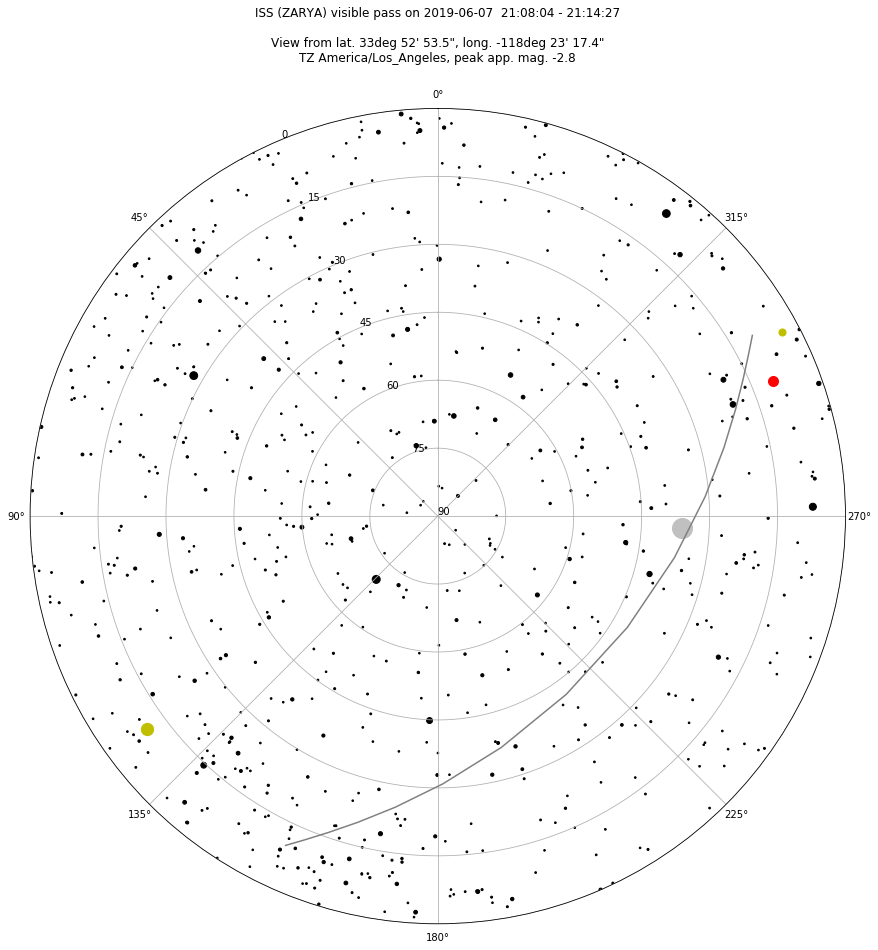

In [16]:
satplot.satellite_pass_chart(passes[26], ephemeris, bright_stars)